# Stock Return Predictions


In [11]:
from keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPooling1D
from keras.models import Model

# from keras.optimizers import Adam   # For macos compatibility
from keras.optimizers.legacy import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Import data and analysis


In [12]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv'
)
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [13]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


## Wrong way of doing the stock price analysis


In [14]:
# doing the wrong thing (trying to predict the price itself)
series = df['close'].values.reshape(-1, 1)

In [15]:
# Normalizing the data
scaler = StandardScaler()
scaler.fit(series[: len(series) // 2])

series = scaler.transform(series).flatten()

In [26]:
# Building dataset
T = 10
D = 1

X = []
Y = []

for t in range(len(series) - T):
    x = series[t : T + t]
    y = series[T + t]

    X.append(x)
    Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)

N = len(X)

In [27]:
# Checking shapes
X.shape, Y.shape

((1249, 10, 1), (1249,))

In [28]:
# Autoregressive RNN model
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)

model = Model(i, x)

# Compiling model
model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.1),
)

# Training model
r = model.fit(
    X[: -N // 2],
    Y[: -N // 2],
    epochs=80,
    validation_data=(
        X[-N // 2 :],
        Y[-N // 2 :],
    ),
)

Epoch 1/80
20/20 [==============================] - 1s 9ms/step - loss: 0.1918 - val_loss: 0.1103
Epoch 2/80
20/20 [==============================] - 0s 2ms/step - loss: 0.0104 - val_loss: 0.0337
Epoch 3/80
20/20 [==============================] - 0s 2ms/step - loss: 0.0077 - val_loss: 0.0298
Epoch 4/80
20/20 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0240
Epoch 5/80
20/20 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0243
Epoch 6/80
20/20 [==============================] - 0s 2ms/step - loss: 0.0058 - val_loss: 0.0276
Epoch 7/80
20/20 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0363
Epoch 8/80
20/20 [==============================] - 0s 2ms/step - loss: 0.0063 - val_loss: 0.0266
Epoch 9/80
20/20 [==============================] - 0s 2ms/step - loss: 0.0055 - val_loss: 0.0235
Epoch 10/80
20/20 [==============================] - 0s 2ms/step - loss: 0.0060 - val_loss: 0.0481
Epoch 11/80
20/20 [

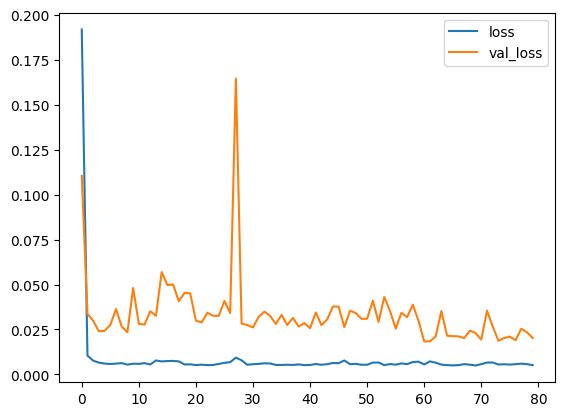

In [29]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

40/40 [==============================] - 0s 441us/step


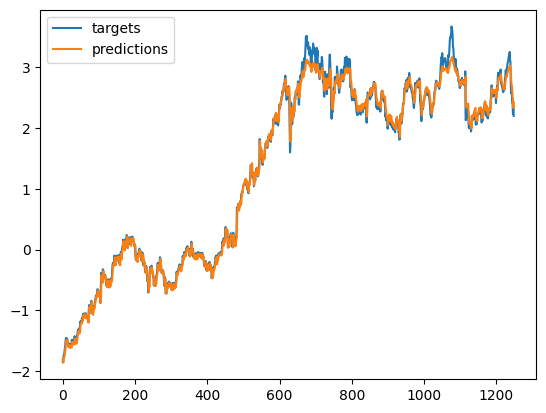

In [31]:
# One step forecast using true targets
outputs = model.predict(X)
predictions = outputs[:, 0]


plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 7ms/step


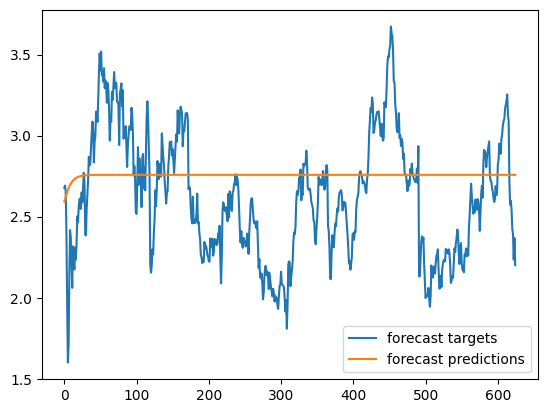

In [32]:
# Multi-step forecast
validation_target = Y[-N // 2 :]
validation_predictions = []

# First validation input
last_x = X[-N // 2]

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, T, 1))[0, 0]  # 1x1 array -> scalar

    validation_predictions.append(p)

    last_x = np.roll(last_x, -1)
    last_x[-1] = p

plt.plot(validation_target, label='forecast targets')
plt.plot(validation_predictions, label='forecast predictions')
plt.legend()
plt.show()

## Correct way


In [33]:
# Calculate returns by first shifting the data
df['prev_close'] = df['close'].shift(1)

df.head()

,date,open,high,low,close,volume,Name,prev_close
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [34]:
# Calculating return
df['return'] = (df['close'] - df['prev_close']) / df['prev_close']

df.head()

,date,open,high,low,close,volume,Name,prev_close,return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


<Axes: >

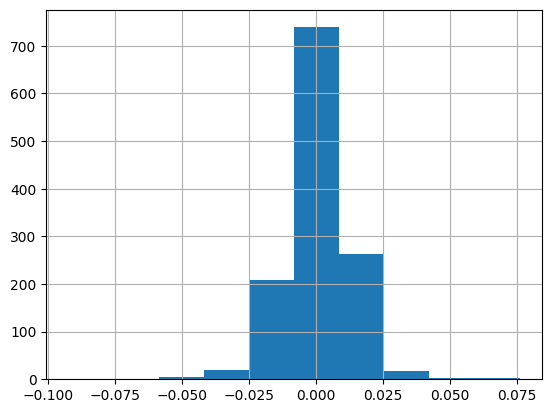

In [35]:
# Plotting return
df['return'].hist()

### LSTMs and regression


In [36]:
# Using LSTM
series = df['return'].values[1:].reshape(-1, 1)

# Normalizing data
scaler = StandardScaler()
scaler.fit(series[: len(series) // 2])

series = scaler.transform(series).flatten()

In [37]:
# Rebuilding the dataset
X = []
Y = []

for t in range(len(series) - T):
    x = series[t : T + t]
    y = series[T + t]

    X.append(x)
    Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)

N = len(X)

In [38]:
# Checking shapes
X.shape, Y.shape

((1248, 10, 1), (1248,))

In [40]:
# Rebuilding model with lower
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)

model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=0.01),
)

r = model.fit(
    X[: -N // 2],
    Y[: -N // 2],
    epochs=80,
    validation_data=(
        X[-N // 2 :],
        Y[-N // 2 :],
    ),
)

Epoch 1/80
20/20 [==============================] - 1s 12ms/step - loss: 0.9914 - val_loss: 1.1612
Epoch 2/80
20/20 [==============================] - 0s 2ms/step - loss: 0.9859 - val_loss: 1.1507
Epoch 3/80
20/20 [==============================] - 0s 2ms/step - loss: 0.9834 - val_loss: 1.1525
Epoch 4/80
20/20 [==============================] - 0s 2ms/step - loss: 0.9863 - val_loss: 1.1497
Epoch 5/80
20/20 [==============================] - 0s 2ms/step - loss: 0.9835 - val_loss: 1.1599
Epoch 6/80
20/20 [==============================] - 0s 2ms/step - loss: 0.9818 - val_loss: 1.1502
Epoch 7/80
20/20 [==============================] - 0s 2ms/step - loss: 0.9812 - val_loss: 1.1485
Epoch 8/80
20/20 [==============================] - 0s 2ms/step - loss: 0.9792 - val_loss: 1.1601
Epoch 9/80
20/20 [==============================] - 0s 2ms/step - loss: 0.9795 - val_loss: 1.1652
Epoch 10/80
20/20 [==============================] - 0s 2ms/step - loss: 0.9799 - val_loss: 1.1582
Epoch 11/80
20/20 

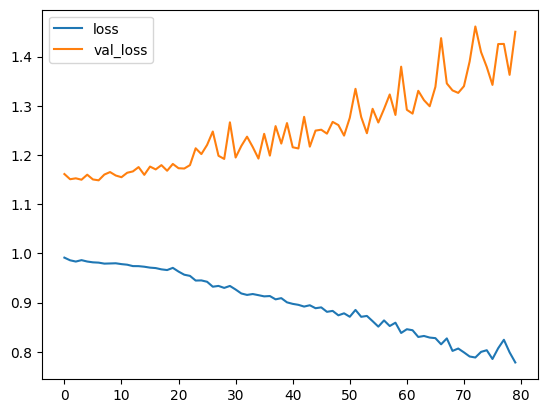

In [42]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

39/39 [==============================] - 0s 519us/step


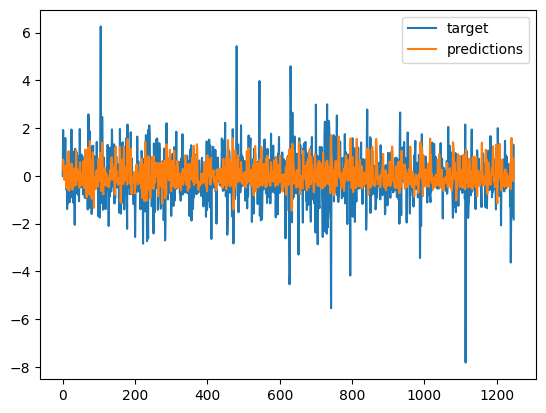

In [ ]:
# One-step forecast using true targets
outputs = model.predict(X)
predictions = outputs[:, 0]

plt.plot(Y, label='target')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

1/1 [==============================] - 0s 8ms/step


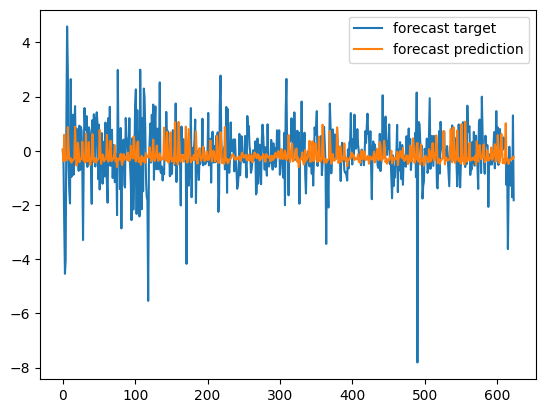

In [ ]:
# Multi-step forecast
validation_target = Y[-N // 2 :]
validation_predictions = []

last_x = X[-N // 2]

while len(validation_predictions) < len(validation_target):
    p = model.predict(last_x.reshape(1, T, 1))[0, 0]

    validation_predictions.append(p)

    last_x = np.roll(last_x, -1)
    last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

### LSTMs and classification


In [69]:
# Turning all of the data into numpy arrays
input_data = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['return'].values

In [70]:
# Creating acutal data
T = 10
D = input_data.shape[1]
N = len(input_data) - T

In [91]:
# Normalizing the inputs
N_train = len(input_data) * 2 // 3

scaler = StandardScaler()
scaler.fit(input_data[: N_train + T])

input_data = scaler.transform(input_data)

In [ ]:
# Setup X_train and Y_train
X_train = np.zeros((N_train, T, D))
Y_train = np.zeros(N_train)

for t in range(N_train):
    X_train[t, :, :] = input_data[t : t + T]
    Y_train[t] = targets[t + T] > 0

In [ ]:
# Setup X_test and Y_test
X_test = np.zeros((N - N_train, T, D))
Y_test = np.zeros(N - N_train)

for u in range(N - N_train):
    t = u + N_train
    X_test[u, :, :] = input_data[t : t + T]
    Y_test[u] = targets[t + T] > 0

In [94]:
# Creating model
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)

# Compiling model
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy'],
)

In [95]:
# Training model
r = model.fit(
    X_train,
    Y_train,
    batch_size=32,
    epochs=300,
    validation_data=(X_test, Y_test),
)

Epoch 1/300
27/27 [==============================] - 1s 8ms/step - loss: 0.6933 - accuracy: 0.5292 - val_loss: 0.6927 - val_accuracy: 0.4878
Epoch 2/300
27/27 [==============================] - 0s 2ms/step - loss: 0.6915 - accuracy: 0.5221 - val_loss: 0.6955 - val_accuracy: 0.4854
Epoch 3/300
27/27 [==============================] - 0s 2ms/step - loss: 0.6912 - accuracy: 0.5328 - val_loss: 0.6964 - val_accuracy: 0.4951
Epoch 4/300
27/27 [==============================] - 0s 2ms/step - loss: 0.6908 - accuracy: 0.5268 - val_loss: 0.6951 - val_accuracy: 0.4976
Epoch 5/300
27/27 [==============================] - 0s 2ms/step - loss: 0.6911 - accuracy: 0.5244 - val_loss: 0.6928 - val_accuracy: 0.4927
Epoch 6/300
27/27 [==============================] - 0s 2ms/step - loss: 0.6914 - accuracy: 0.5077 - val_loss: 0.6912 - val_accuracy: 0.5073
Epoch 7/300
27/27 [==============================] - 0s 2ms/step - loss: 0.6901 - accuracy: 0.5077 - val_loss: 0.6926 - val_accuracy: 0.5024
Epoch 8/300
2

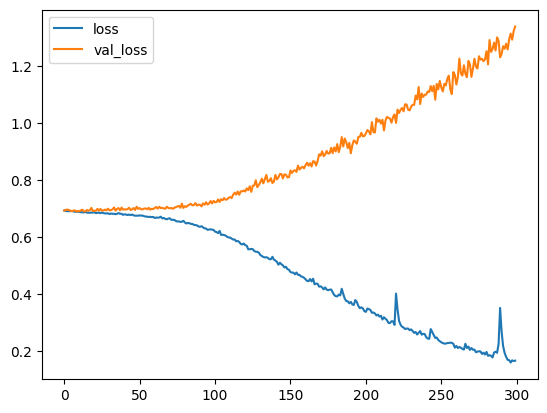

In [96]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

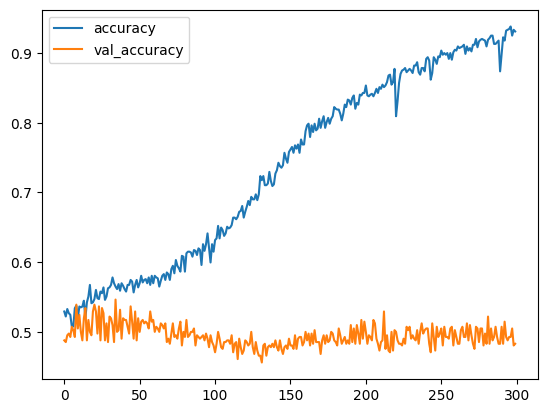

In [97]:
# plot the accuracy
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()